In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
# sudo apt-get install texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra
fontsize=25

def replace_graph_names(df):
    df["Input Graph"] = df["Input Graph"].str.replace("com-", "", regex=True)\
                                    .str.replace(".gbbs.txt", "", regex=True)\
                                    .str.replace(".bin", "", regex=True)\
                                    .str.replace(".ungraph.txt", "", regex=True)\
                                    .str.replace(".graph.txt", "", regex=True)

def set_face_grid_ax_ticks(g):
    """Set fontsize for x and y axis ticks for all axes in a FacetGrid."""
    for ax in g.axes.flat:
        set_ax_ticks(ax)


def set_ax_ticks(ax):
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(fontsize)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(fontsize)
        
def common_ax_style(ax):
    ax.set_xticks([1, 4, 8, 16, 30, 60])
    ax.set_xticklabels([1, 4, 8, 16, 30, "30h"])
    
    ax.set_yscale('log')
    # plt.yticks([0.03, 0.1, 0.3, 1])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    set_ax_ticks(ax)
        
    ax.set_xlabel("Threads", fontsize = fontsize)

def plot_data(df, ax):
    sns.lineplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", linewidth = 3, ax = ax)
    sns.scatterplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", s = 30, ax = ax, legend=False)

def get_larger_handles(g, marker_size, ncol):
    g.add_legend(loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.15), fontsize=fontsize)
    if g._legend:
        for leg_handle in g._legend.legendHandles:
            leg_handle._sizes = [marker_size]

# Function to extract epsilon value from the config
def extract_epsilon(config):
    parts = config.split(',')
    for part in parts:
        if 'epsilon' in part:
            return part.split(':')[-1].strip()
    return None

def postpend_epsilon(df):
    df.loc[:, 'Clusterer Name'] = df.apply(lambda row: f"{row['Clusterer Name']}_{extract_epsilon(row['Config'])}", axis=1)

def add_epsilon_to_hac(df, remove_zero_eps = True):
    df_no_parhac = df[df["Clusterer Name"] != "ParHacClusterer"]
    df_parhac = df[df["Clusterer Name"] == "ParHacClusterer"]

    # split parhac to different methods for different epsilon
    postpend_epsilon(df_parhac)
    
    if remove_zero_eps:
        df_parhac = df_parhac[df_parhac["Clusterer Name"] != "ParHacClusterer_0"]

    df_new = pd.concat([df_no_parhac, df_parhac])
    
    return df_new

def remove_small_f1_methods(df):
    # filter out methods that can achieve > 0.5 * max f1 score
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        df_graph = df[df["Input Graph"] == graph]
        max_f1 = df_graph["fScore_mean"].max()
        print(graph, max_f1)
        df_graph_filtered = df_graph[df_graph["fScore_mean"] > 0.5 * max_f1]
        methods = df_graph_filtered["Clusterer Name"].unique()
        df_graph = df_graph[df_graph["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df

In [76]:
def GetParetoDfs(df):
    dfs = {}

    graphs = df["Input Graph"].unique()
    for graph in graphs:
        for clusterer in clusterers:
            filtered_df = df[df["Input Graph"] == graph]
            filtered_df = filtered_df[filtered_df["Clusterer Name"] == clusterer]

            filtered_df = filtered_df.sort_values(by=["Cluster Time"])
            pareto_frontier = []
            max_score = float("-inf")

            for _, row in filtered_df.iterrows():
                score = row["fScore_mean"]
                if score > max_score:
                    max_score = score
                    pareto_frontier.append(row)

            pareto_df = pd.DataFrame(pareto_frontier)

            dfs[(graph, clusterer)] = (filtered_df, pareto_df)
    return dfs, graphs

## only leave methods that's on the overall pareto frontier
def filterMethodsOnOverallPareto(df):
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        filtered_df = df[df["Input Graph"] == graph]

        filtered_df = filtered_df.sort_values(by=["Cluster Time"])
        pareto_frontier = []
        max_score = float("-inf")

        for _, row in filtered_df.iterrows():
            score = row["fScore_mean"]
            if score > max_score:
                max_score = score
                pareto_frontier.append(row)

        pareto_df = pd.DataFrame(pareto_frontier)
        methods = pareto_df["Clusterer Name"].unique()
        df_graph = filtered_df[filtered_df["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df

# filter out methods on the overrall Pareto frontier of all methods
def FilterParetoPR(df, by_method = False):
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        filtered_df = df[df["Input Graph"] == graph]

        filtered_df = filtered_df.sort_values(by=["communityPrecision_mean"], ascending=False)
        pareto_frontier = []
        max_score = float("-inf")

        for _, row in filtered_df.iterrows():
            score = row["communityRecall_mean"]
            if score > max_score:
                max_score = score
                pareto_frontier.append(row)


        pareto_df = pd.DataFrame(pareto_frontier)
        methods = pareto_df["Clusterer Name"].unique()
        df_graph = filtered_df[filtered_df["Clusterer Name"].isin(methods)]
        if by_method:
            dfs.append(df_graph)
        else:
            dfs.append(pareto_df)
    dfnew = pd.concat(dfs)
    return dfnew

## for each method, find the pareto frontier of precision-recall line
def FilterParetoPRMethod(df):
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        methods = df["Clusterer Name"].unique()
        for method in methods:
            filtered_df = df[(df["Input Graph"] == graph) & (df["Clusterer Name"] == method)]
            filtered_df = filtered_df.sort_values(by=["communityPrecision_mean"], ascending=False)
            pareto_frontier = []
            max_score = float("-inf")

            for _, row in filtered_df.iterrows():
                score = row["communityRecall_mean"]
                if score > max_score:
                    max_score = score
                    pareto_frontier.append(row)


            pareto_df = pd.DataFrame(pareto_frontier)
#             methods = pareto_df["Clusterer Name"].unique()
#             df_graph = filtered_df[filtered_df["Clusterer Name"].isin(methods)]
            dfs.append(pareto_df)
    dfnew = pd.concat(dfs)
    return dfnew

def plotPareto(dfs, graphs):
    plt.rcParams.update({'font.size': 14})

    # Create subplots in a 2x3 grid
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    graph_idx = 0

    lines = []  # To store the Line2D objects for the legend
    labels = []  # To store the corresponding labels for the Line2D objects

    for i in range(2):
        for j in range(3):
            if graph_idx < len(graphs):  # Ensure we have a graph to process
                graph = graphs[graph_idx]
                ax = axes[i][j]

                for clusterer in clusterers:
                    # Extract the pareto_df for the current graph and clusterer combination
                    _, pareto_df = dfs[(graph, clusterer)]
                    if pareto_df.empty:
#                         print(graph, clusterer)
                        continue

                    # Plot the pareto_df with the appropriate marker
                    line, = ax.plot(pareto_df["Cluster Time"], pareto_df["fScore_mean"], label=clusterer, 
                                    color=color_map[clusterer], marker=style_map[clusterer], markersize=16, linewidth=2)

                    shortened_clusterer = clusterer.replace("Clusterer", "")
                    # If the clusterer's line hasn't been added to lines, add it
                    if shortened_clusterer not in labels:
                        lines.append(line)
                        labels.append(shortened_clusterer)

                ax.set_title(f"Pareto Frontier for {graph}")
                ax.set_xlabel("Cluster Time")
                ax.set_ylabel("fScore_mean")

                graph_idx += 1
            else:
                axes[i][j].axis('off')  # Turn off axes without data


    # Create a single legend for the entire figure, at the top
    fig.legend(lines, labels, loc='upper center', ncol=7, bbox_to_anchor=(0.5, 1.08), frameon=False)

def plotPRPareto(df):
    plt.rcParams.update({'font.size': 14})
    graphs = df["Input Graph"].unique()

    # Create subplots in a 2x3 grid
#     fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 16))
    graph_idx = 0

    lines = []  # To store the Line2D objects for the legend
    labels = []  # To store the corresponding labels for the Line2D objects

    for i in range(2):
        for j in range(3):
            if graph_idx < len(graphs):  # Ensure we have a graph to process
                graph = graphs[graph_idx]
#                 ax = axes[i][j]
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))


                for clusterer in clusterers:
                    # Extract the pareto_df for the current graph and clusterer combination
                    pareto_df = df[(df["Clusterer Name"] == clusterer) & (df["Input Graph"]==graph)]
                    if pareto_df.empty:
#                         print(graph, clusterer)
                        continue

                    # Plot the pareto_df with the appropriate marker
                    line, = ax.plot(pareto_df["communityPrecision_mean"], pareto_df["communityRecall_mean"], label=clusterer, 
                                    color=color_map[clusterer], marker=style_map[clusterer], markersize=16, linewidth=2)

                    shortened_clusterer = clusterer.replace("Clusterer", "")
                    # If the clusterer's line hasn't been added to lines, add it
                    if shortened_clusterer not in labels:
                        lines.append(line)
                        labels.append(shortened_clusterer)

                ax.set_title(f"{graph}")
                ax.set_xlabel("Precision")
                ax.set_ylabel("Recall")

                graph_idx += 1
                
                fig.subplots_adjust(hspace=0.4)
                fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.08), frameon=False)
            else:
                pass
#                 axes[i][j].axis('off')  # Turn off axes without data


#     fig.subplots_adjust(hspace=0.4)
#     fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.08), frameon=False)
    
# compute the area under the precision recall pareto curve, for precision >= 0.5.
def computeAUC(df_pr_pareto, clusterer, graph):
    df = df_pr_pareto[(df_pr_pareto["Clusterer Name"] == clusterer) & (df_pr_pareto["Input Graph"]==graph)][["communityPrecision_mean", "communityRecall_mean"]]
    
    # Filter the DataFrame to include only precision values in the range [0.5, 1]
    filtered_df = df[df['communityPrecision_mean'] >= 0.5]
    
    if len(filtered_df)==0:
        return 0
    
    # Find the row with the smallest precision in the filtered DataFrame
    min_precision_row = filtered_df[filtered_df['communityPrecision_mean'] == filtered_df['communityPrecision_mean'].min()]

    # Extract the recall value corresponding to the smallest precision
    recall_value = min_precision_row['communityRecall_mean'].values[0]
    
    # Create a new row with precision = 0.5 and recall = recall_value
    new_row = pd.DataFrame({'communityPrecision_mean': [0.5, 1], 'communityRecall_mean': [recall_value, 0]})


    # Concatenate the new row to the DataFrame
    filtered_df = pd.concat([filtered_df, new_row], ignore_index=True)

    # Sort the filtered DataFrame by 'communityPrecision_mean'
    filtered_df.sort_values(by='communityPrecision_mean', inplace=True)
    

    # Calculate the area under the curve using the trapezoidal rule
    area = np.trapz(filtered_df['communityRecall_mean'], filtered_df['communityPrecision_mean'])
    
    return area

def getAUCTable(df, df_pr_pareto, print_table = False):
    graphs = df["Input Graph"].unique()
    methods = df["Clusterer Name"].unique()
    data = {}
    for graph in graphs:
        aucs = []
        for method in methods:
            auc = computeAUC(df_pr_pareto, method, graph)
            aucs.append(auc)
        data[graph] = aucs
    data["method"] = [method.replace("Clusterer", "").replace("_", "-").replace("Parallel", "").replace("LabelPropagation", "LP")  
                      for method in methods]
    df_auc = pd.DataFrame(data)

    # Set the 'method' column as the index
    df_auc.set_index('method', inplace=True)
    df_auc['avg'] = df_auc.mean(axis=1)


    bold_df = df_auc.apply(lambda x: ['\\textbf{{ {:.2f} }}'.format(val) if val == x.max() else '{:.2f}'.format(val) for val in x])

    # Convert the DataFrame with bold formatting to LaTeX
    latex_table = bold_df.to_latex(escape=False)
    if print_table:
        print(bold_df)


    # Print the LaTeX table
    print(latex_table)

In [3]:
base_addr = "/Users/sy/Desktop/MIT/clusterer/csv/"

In [72]:
df = pd.read_csv(base_addr + "uci_results/out_uci_google_csv/stats.csv")
df2 = pd.read_csv(base_addr + "uci_results/out_uci_ours_csv/stats.csv")
df_affinity = pd.read_csv(base_addr + "uci_results/stats_affinity.csv")
df_hac = pd.read_csv(base_addr + "uci_results/stats_parhac.csv")
df_parcc = pd.read_csv(base_addr + "uci_results/stats_parcc.csv")
df_ldd = pd.read_csv(base_addr + "uci_results/stats_ldd.csv")
df_tectonic = pd.read_csv(base_addr + "uci_results/stats_tectonic.csv")
df_wcc = pd.read_csv(base_addr + "uci_results/stats_wcc.csv")
df = pd.concat([df, df2, df_affinity, df_hac, df_parcc, df_tectonic, df_wcc])

df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)

In [23]:
clusterers = df["Clusterer Name"].unique()
cmap = plt.cm.tab20

# Ensure there are enough colors for the values
assert len(clusterers) <= cmap.N, "Not enough colors in the colormap for the clusterer values"

colors = [cmap(i) for i in range(len(clusterers))]

color_map = dict(zip(clusterers, colors))

# Define a list of marker styles
marker_styles = ['o', 's', '^', 'P', 'd', 'X', 'v', '<', '>', '*', '*', '*', '*', '*', 'D']

# Ensure there are enough markers for the clusterer values
assert len(clusterers) <= len(marker_styles), "Not enough marker styles for the clusterer values"

# Create a style_map that maps each value in clusterer values to a marker style
style_map = dict(zip(clusterers, marker_styles))


In [77]:
df_pr_pareto = FilterParetoPRMethod(df)
getAUCTable(df, df_pr_pareto)

\begin{tabular}{lllllll}
\toprule
 & faces & iris & digits & wdbc & wine & avg \\
method &  &  &  &  &  &  \\
\midrule
Affinity & \textbf{ 0.31 } & 0.46 & 0.46 & 0.41 & 0.24 & 0.37 \\
Correlation & 0.29 & 0.30 & 0.21 & 0.08 & 0.12 & 0.20 \\
Modularity & 0.27 & 0.30 & 0.22 & 0.07 & 0.14 & 0.20 \\
KCore & 0.05 & 0.01 & 0.00 & 0.00 & 0.01 & 0.01 \\
LDD & 0.00 & 0.28 & 0.00 & 0.25 & 0.22 & 0.15 \\
Scan & 0.15 & 0.45 & 0.39 & 0.32 & 0.21 & 0.30 \\
LP & 0.00 & 0.25 & 0.21 & 0.06 & 0.13 & 0.13 \\
SLPA & 0.00 & 0.27 & 0.21 & 0.06 & 0.13 & 0.13 \\
Tectonic & 0.26 & \textbf{ 0.47 } & 0.44 & 0.24 & 0.25 & 0.33 \\
Connectivity & 0.07 & 0.36 & 0.01 & 0.17 & 0.19 & 0.16 \\
ParHac-0.01 & 0.31 & 0.46 & \textbf{ 0.46 } & 0.37 & \textbf{ 0.27 } & 0.38 \\
ParHac-0.1 & 0.30 & 0.47 & 0.46 & 0.41 & 0.27 & \textbf{ 0.38 } \\
ParHac-1 & 0.19 & 0.46 & 0.44 & \textbf{ 0.43 } & 0.26 & 0.36 \\
\bottomrule
\end{tabular}



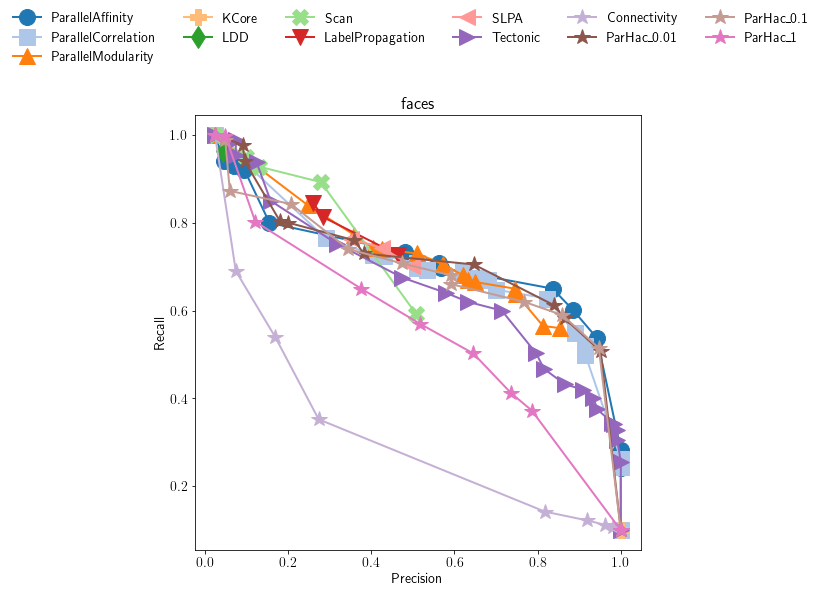

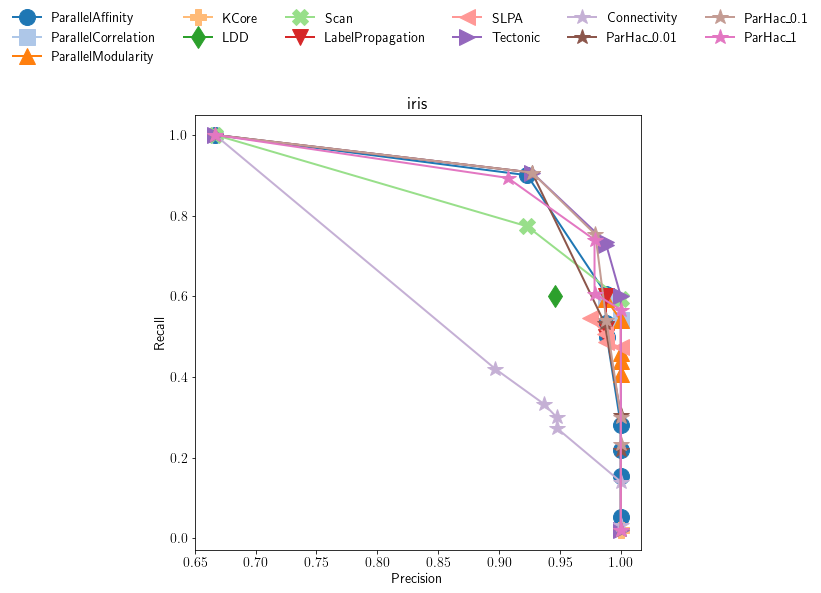

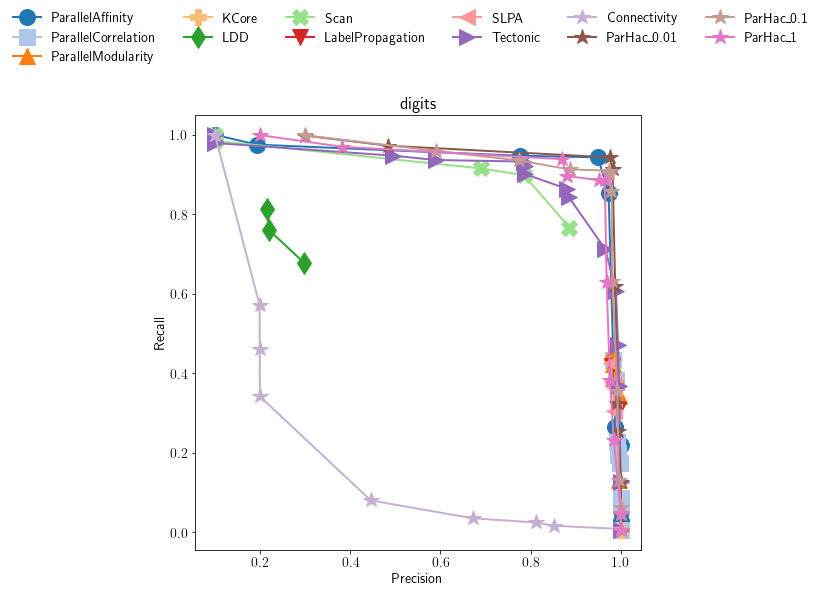

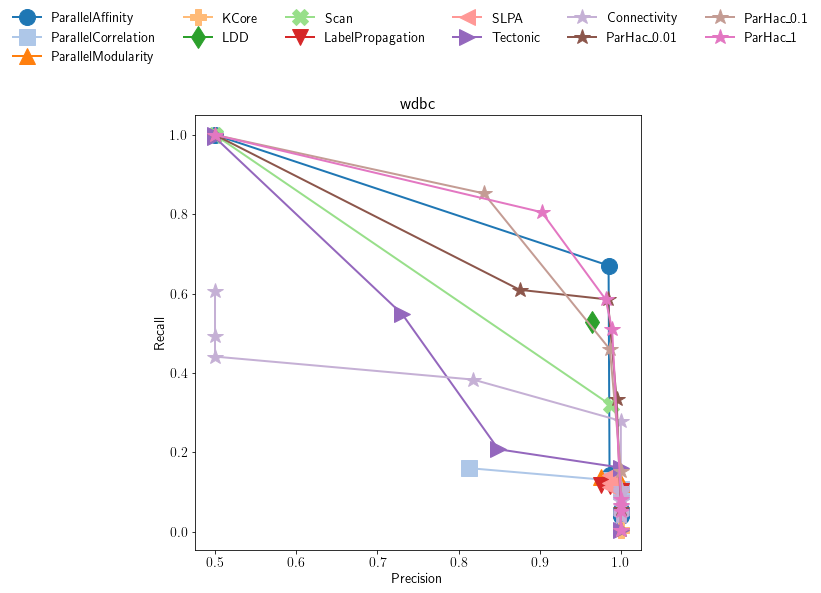

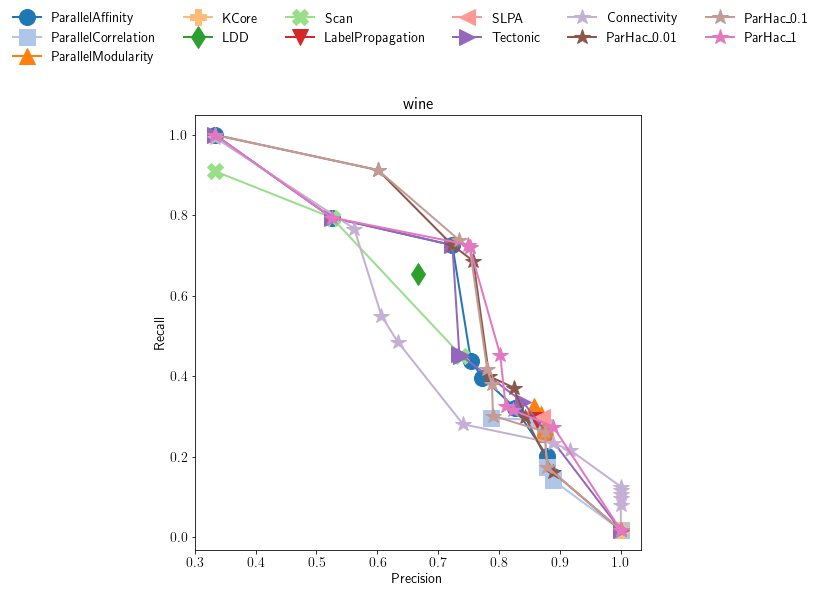

In [35]:
plotPRPareto(df_pr_pareto)

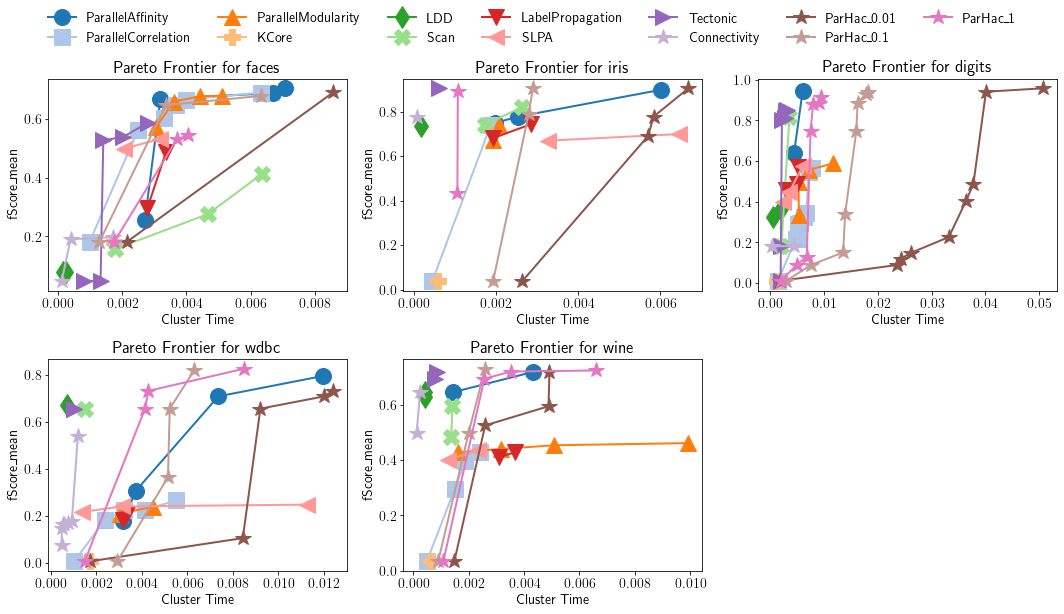

In [58]:
dfs, graphs = GetParetoDfs(df)
plotPareto(dfs, graphs)
plt.tight_layout()
# plt.savefig("../results/out_time_f1_uci.pdf", bbox_inches='tight')

In [36]:
# filtered_df = remove_small_f1_methods(df)
# filtered_df = filterMethodsOnOverallPareto(filtered_df)
# filtered_dfs, graphs = GetParetoDfs(filtered_df)
# plotPareto(filtered_dfs, graphs)
# plt.tight_layout()

In [46]:
# old_fontsize = fontsize
# fontsize = 60
# g = sns.FacetGrid(df, col="Input Graph", col_wrap=3, height = 10, aspect =0.4, xlim=(0, 1.1), ylim=(0,1.1)) # col_wrap decides the number of plots per row
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean", hue="Clusterer Name",
#                 s=3000, palette = color_map, style="Clusterer Name",  markers=style_map, alpha = 0.8)

# g.set_titles(size=fontsize)  # Set title font size for FacetGrid plots
# g.set_axis_labels("Precision", "Recall", fontsize=fontsize)  # Set

# # Add a legend
# get_larger_handles(g, 4000, 6)

# set_face_grid_ax_ticks(g)
# plt.tight_layout()
# # plt.savefig("../results/out_precision_recall_uci.pdf", bbox_inches='tight')
# fontsize=old_fontsize

### Larger Weighted Graphs




In [78]:
df = pd.read_csv(base_addr + "weighted_results/stats_mnist.csv")
df_imagenet = pd.read_csv(base_addr + "weighted_results/stats_imagenet.csv")
df_larger = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_50.csv")
df_larger2 = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_more_50.csv")
df_10 = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_10.csv")
df_100 = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_100.csv")
df = pd.concat([df, df_larger, df_larger2, df_imagenet, df_10, df_100])

df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)
df_50 = df[df["Input Graph"].isin(["mnist_k50", "imagenet_k50", "arxiv-clustering-p2p_k50", 
                                   "reddit-clustering_k50", "stackexchange-clustering_k50", "amazon_polarity_k50"])]

In [79]:
df_pr_pareto = FilterParetoPRMethod(df_50)
getAUCTable(df_50, df_pr_pareto)

\begin{tabular}{llllllll}
\toprule
 & mnist_k50 & amazon_polarity_k50 & arxiv-clustering-p2p_k50 & reddit-clustering_k50 & stackexchange-clustering_k50 & imagenet_k50 & avg \\
method &  &  &  &  &  &  &  \\
\midrule
Affinity & 0.39 & 0.07 & 0.01 & 0.08 & 0.04 & 0.33 & 0.15 \\
Correlation & 0.24 & 0.11 & 0.01 & 0.14 & 0.09 & 0.30 & 0.15 \\
Modularity & 0.25 & 0.11 & \textbf{ 0.01 } & \textbf{ 0.16 } & \textbf{ 0.10 } & 0.29 & 0.15 \\
LDD & 0.00 & 0.24 & 0.00 & 0.02 & 0.01 & 0.12 & 0.07 \\
Scan & 0.00 & \textbf{ 0.24 } & 0.00 & 0.03 & 0.00 & 0.00 & 0.04 \\
LP & 0.32 & 0.11 & 0.00 & 0.03 & 0.08 & 0.29 & 0.14 \\
SLPA & 0.12 & 0.09 & 0.00 & 0.04 & 0.08 & 0.25 & 0.10 \\
Tectonic & 0.17 & 0.03 & 0.01 & 0.04 & 0.03 & 0.13 & 0.07 \\
Connectivity & 0.00 & 0.15 & 0.01 & 0.00 & 0.00 & 0.00 & 0.03 \\
ParHac-0.01 & \textbf{ 0.43 } & 0.09 & 0.01 & 0.14 & 0.09 & \textbf{ 0.37 } & \textbf{ 0.19 } \\
ParHac-0.1 & 0.41 & 0.06 & 0.01 & 0.14 & 0.09 & 0.36 & 0.18 \\
ParHac-1 & 0.37 & 0.04 & 0.01 & 0.10 & 0.

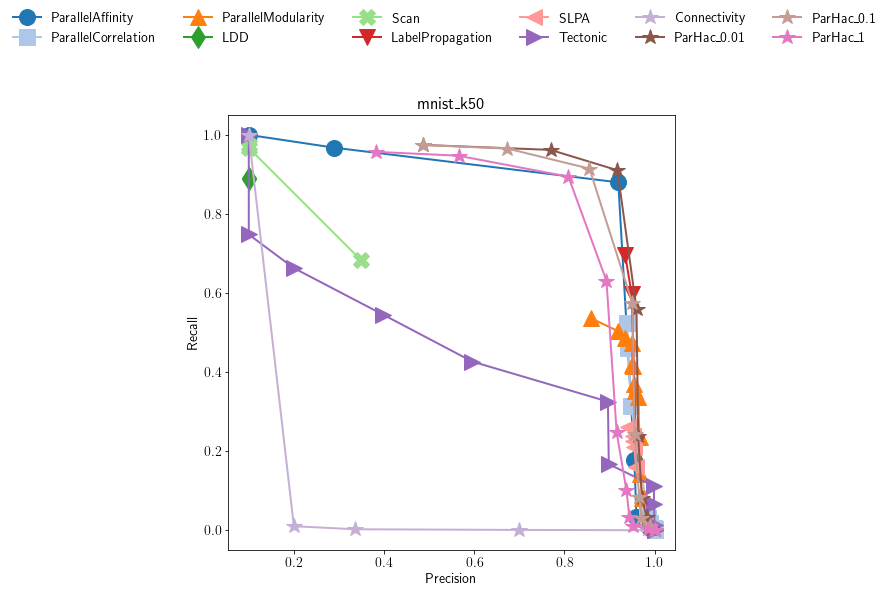

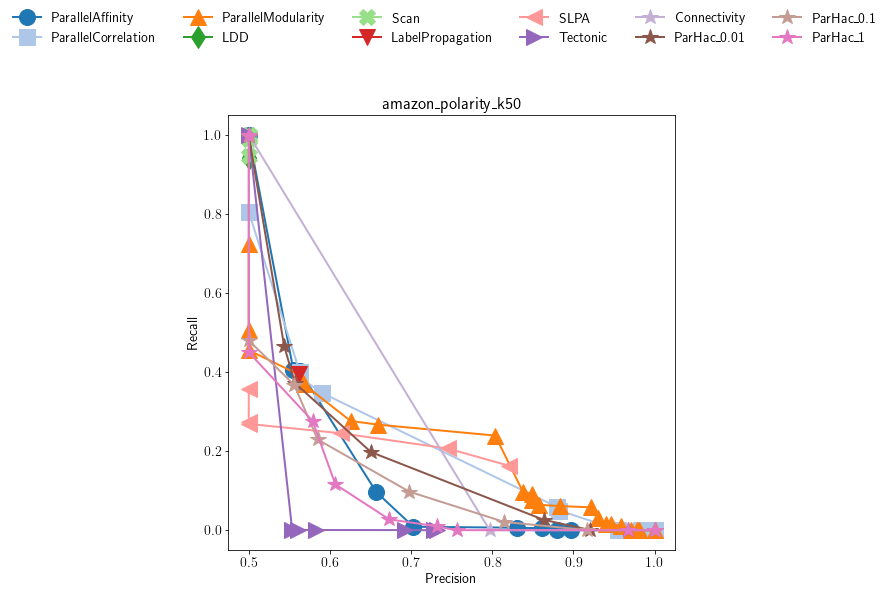

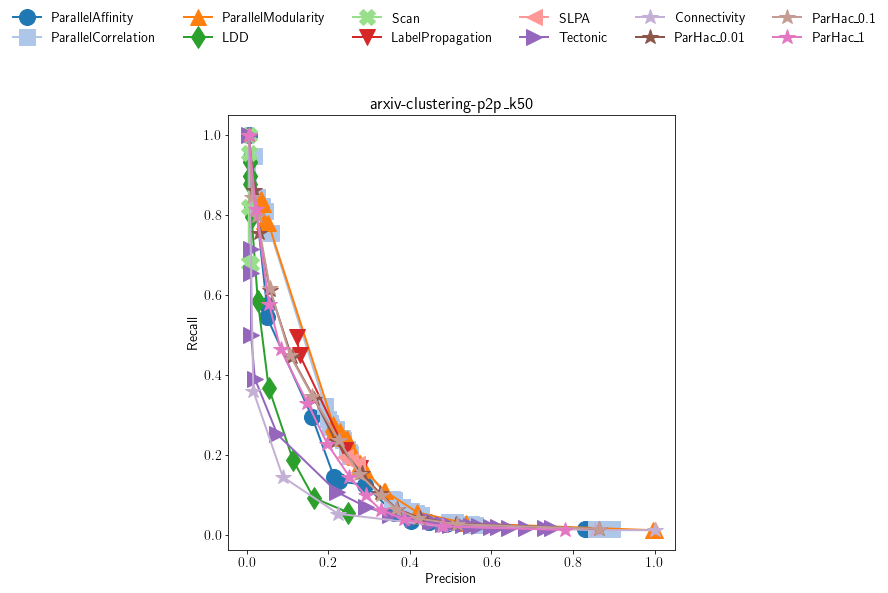

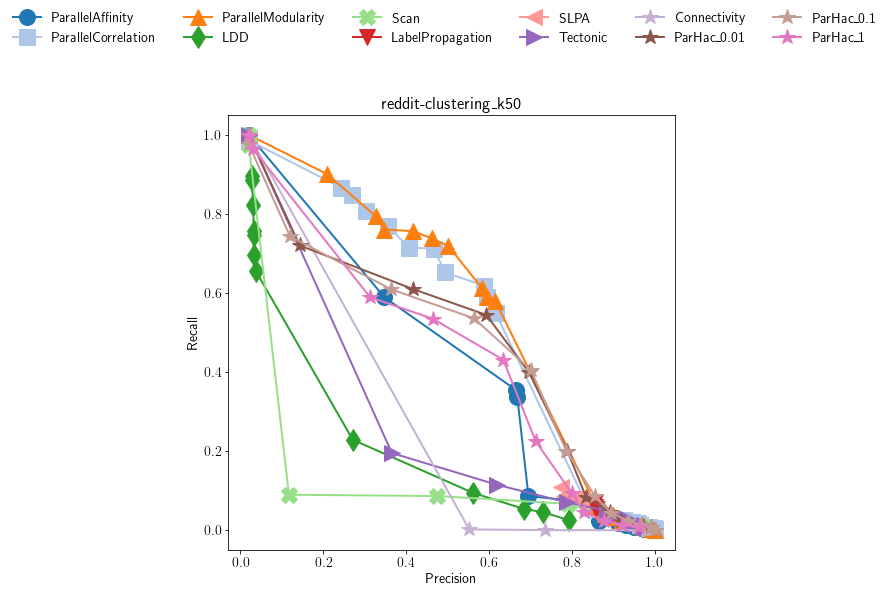

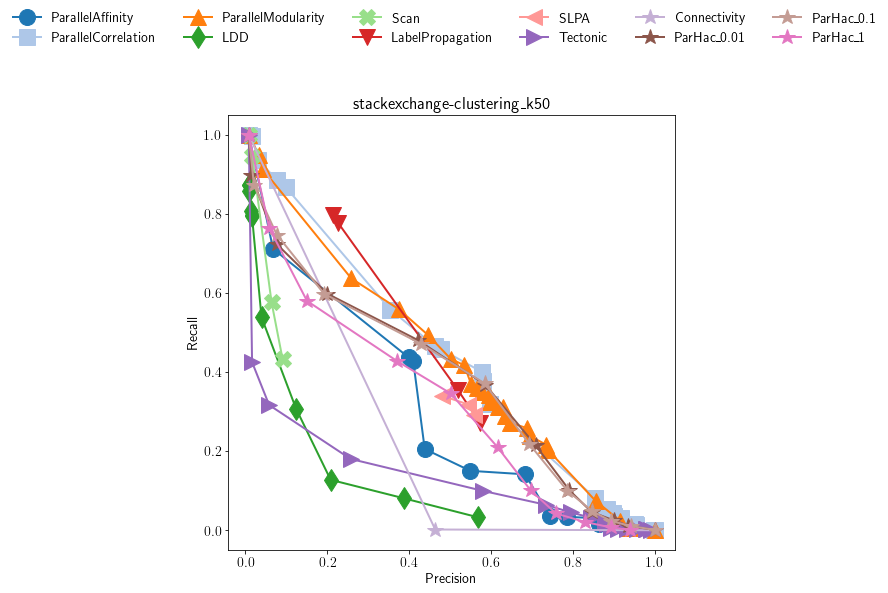

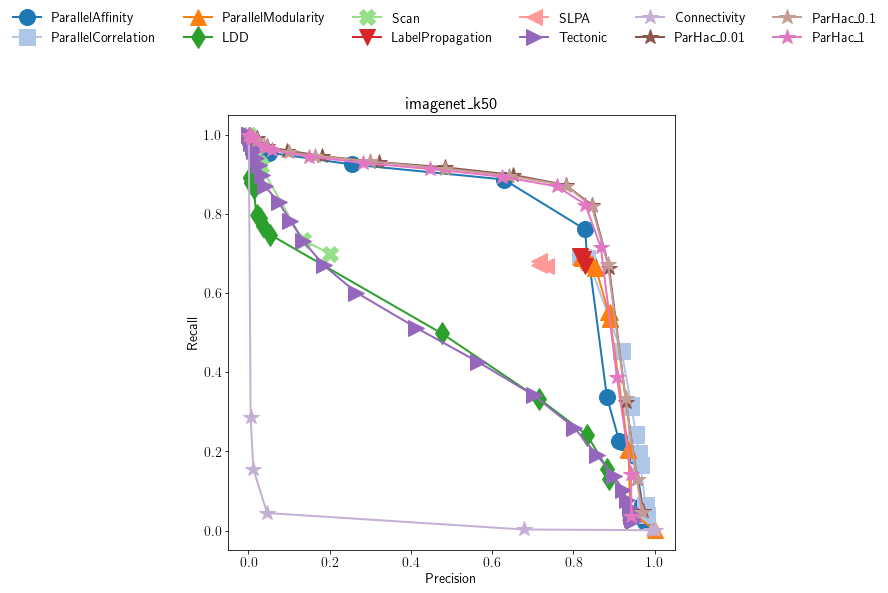

In [38]:
plotPRPareto(df_pr_pareto)

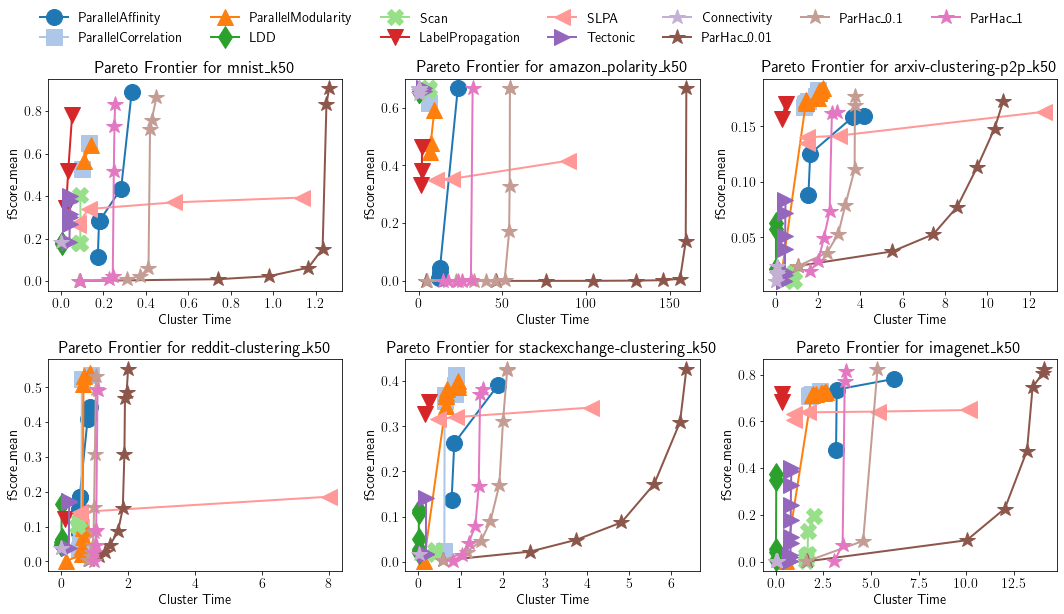

In [66]:
dfs, graphs = GetParetoDfs(df_50)
plt.rcParams.update({'font.size': 14})
plotPareto(dfs, graphs)
plt.tight_layout()
# plt.savefig("../results/out_time_f1_mnist.pdf", bbox_inches='tight')


In [62]:
# g = sns.FacetGrid(df[df["Input Graph"] == "imagenet_k50"], col="Clusterer Name", col_wrap=4,
#                   xlim=(0, 1.1), ylim=(0,1.1))
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean")

In [68]:
# g = sns.FacetGrid(df[df["Input Graph"] == "arxiv-clustering-p2p_k50"], col="Clusterer Name", col_wrap=4,
#                   xlim=(0, 1.1), ylim=(0,1.1))
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean")
# #                 s=3000)

## Compare k

imagenet_k100 0.8262418070991844
arxiv-clustering-p2p_k100 0.1972336881994055
reddit-clustering_k100 0.5665267266905676
stackexchange-clustering_k100 0.4598701375362343


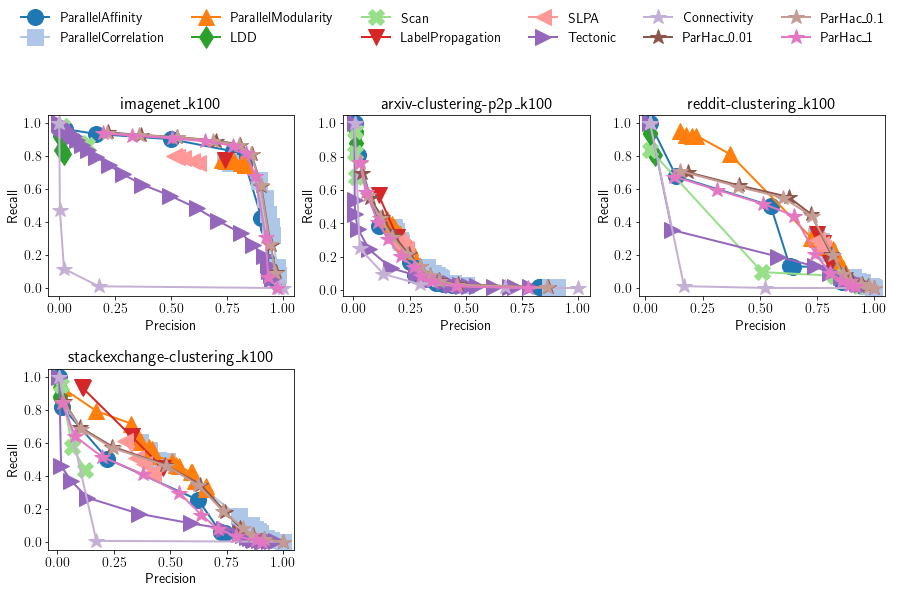

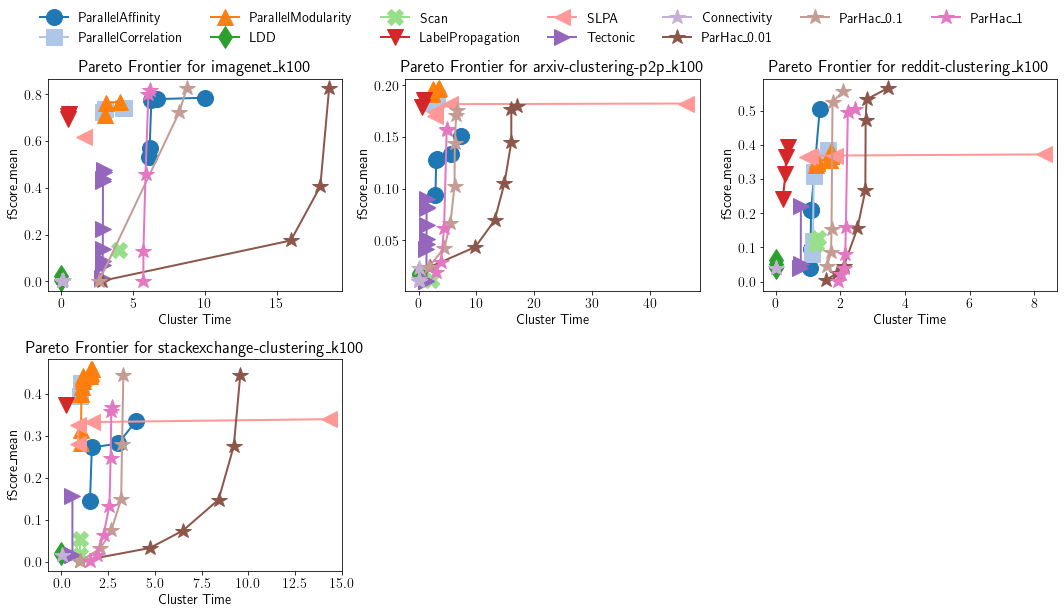

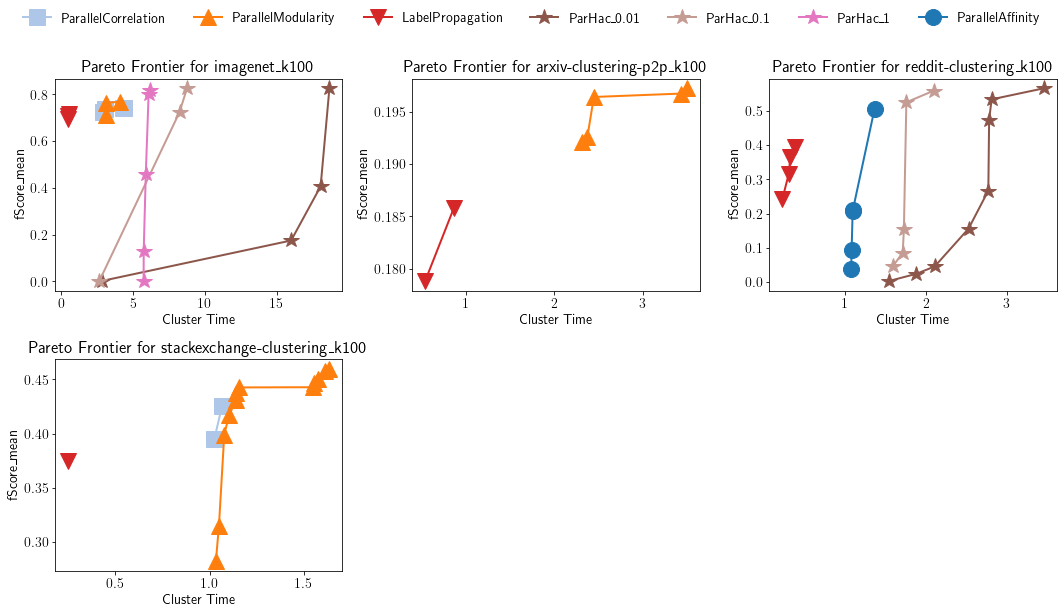

In [90]:
## k=10
k = 100
df_k = df[df["Input Graph"].isin(["mnist_k%s" % k, "imagenet_k%s" % k, "arxiv-clustering-p2p_k%s" % k, 
                                   "reddit-clustering_k%s" % k, "stackexchange-clustering_k%s" % k, 
                                   "amazon_polarity_k%s" % k])]
df_pr_pareto = FilterParetoPRMethod(df_k)
plotPRPareto(df_pr_pareto)

dfs, graphs = GetParetoDfs(df_k)
plt.rcParams.update({'font.size': 14})
plotPareto(dfs, graphs)
plt.tight_layout()
# plt.savefig("../results/out_time_f1_mnist.pdf", bbox_inches='tight')

filtered_df = remove_small_f1_methods(df_k)
filtered_df = filterMethodsOnOverallPareto(filtered_df)
filtered_dfs, graphs = GetParetoDfs(filtered_df)
plotPareto(filtered_dfs, graphs)
plt.tight_layout()


mnist_k10 0.9487557955569834
imagenet_k10 0.8134036838917331
amazon_polarity_k10 0.6666666666666666
arxiv-clustering-p2p_k10 0.1669132928560276
reddit-clustering_k10 0.1561127423637303
stackexchange-clustering_k10 0.3937250185779453


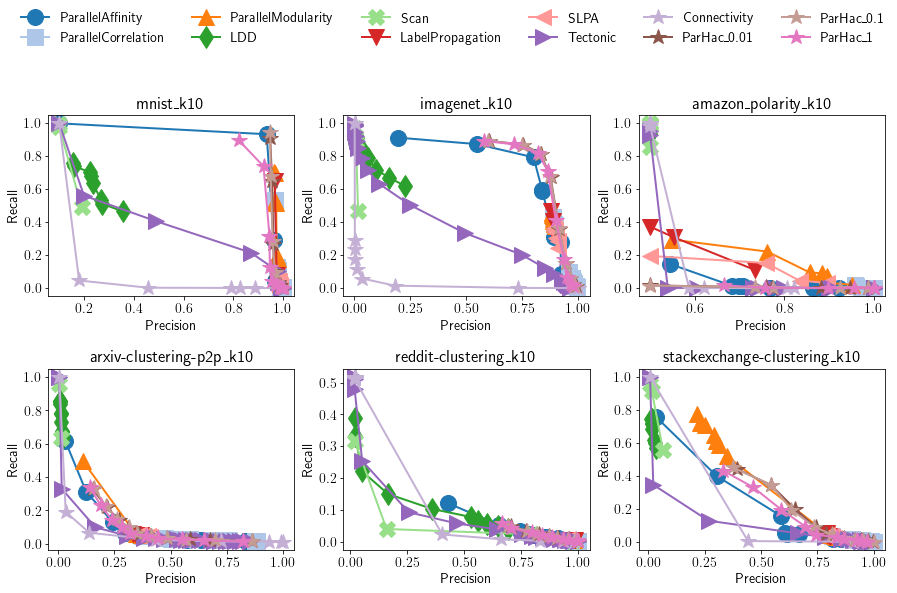

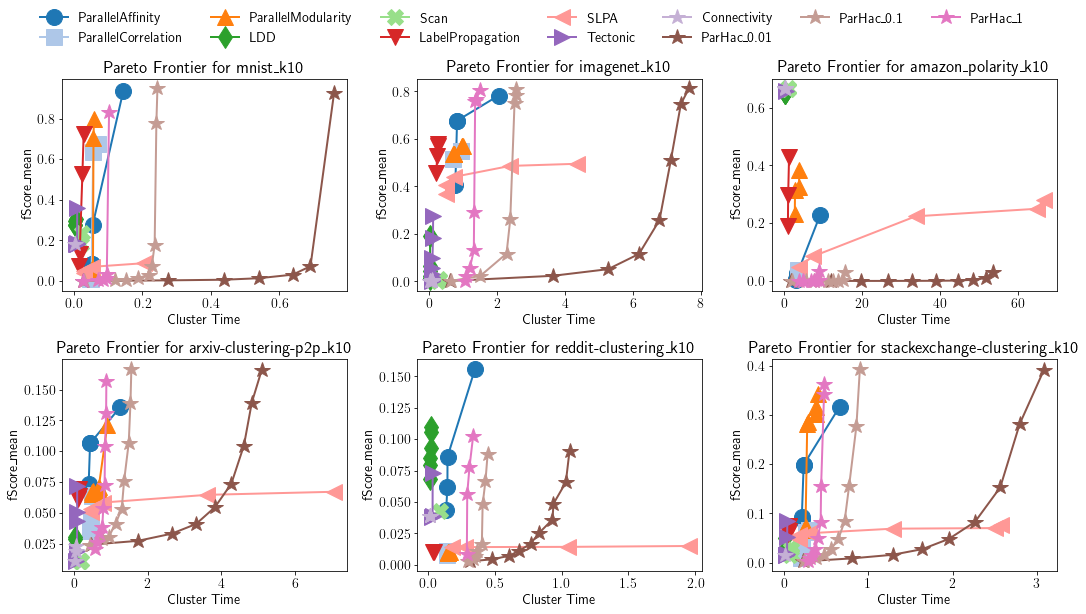

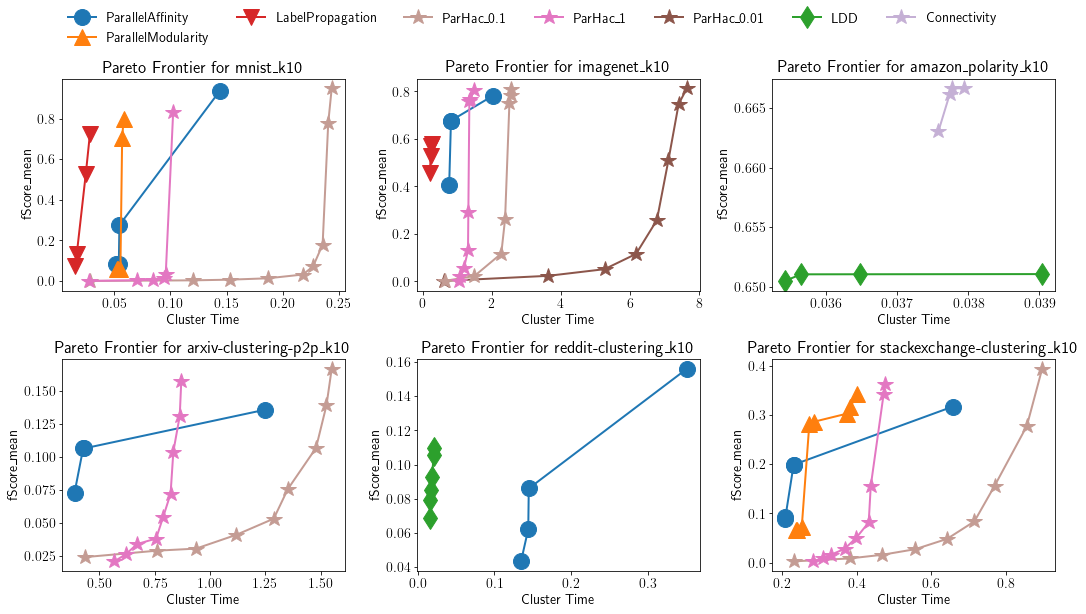

In [91]:
k=10
df_k = df[df["Input Graph"].isin(["mnist_k%s" % k, "imagenet_k%s" % k, "arxiv-clustering-p2p_k%s" % k, 
                                   "reddit-clustering_k%s" % k, "stackexchange-clustering_k%s" % k, 
                                   "amazon_polarity_k%s" % k])]
df_pr_pareto = FilterParetoPRMethod(df_k)
plotPRPareto(df_pr_pareto)

dfs, graphs = GetParetoDfs(df_k)
plt.rcParams.update({'font.size': 14})
plotPareto(dfs, graphs)
plt.tight_layout()
# plt.savefig("../results/out_time_f1_mnist.pdf", bbox_inches='tight')

filtered_df = remove_small_f1_methods(df_k)
filtered_df = filterMethodsOnOverallPareto(filtered_df)
filtered_dfs, graphs = GetParetoDfs(filtered_df)
plotPareto(filtered_dfs, graphs)
plt.tight_layout()


## SNAP

In [80]:
df = pd.read_csv(base_addr + "snap_results/stats_snap_google.csv")
df2 = pd.read_csv(base_addr + "snap_results/stats_snap_ours.csv")
df3 = pd.read_csv(base_addr + "snap_results/stats_snap_more.csv")

df = pd.concat([df, df2, df3])
# df = df[df["Clusterer Name"] != "ConnectivityClusterer"]

df = df.dropna(how='all')
replace_graph_names(df)
# df = remove_small_f1_methods(df)
# df = filterMethodsOnOverallPareto(df)

In [81]:
df_pr_pareto = FilterParetoPRMethod(df)
getAUCTable(df, df_pr_pareto)

\begin{tabular}{llllllll}
\toprule
 & lj & amazon & dblp & youtube & orkut & friendster & avg \\
method &  &  &  &  &  &  &  \\
\midrule
Correlation & \textbf{ 0.36 } & 0.44 & \textbf{ 0.34 } & 0.16 & \textbf{ 0.16 } & \textbf{ 0.22 } & \textbf{ 0.28 } \\
Modularity & 0.32 & 0.43 & 0.31 & 0.20 & 0.09 & 0.12 & 0.25 \\
LDD & 0.20 & 0.30 & 0.19 & 0.12 & 0.00 & 0.00 & 0.13 \\
Scan & 0.30 & 0.44 & 0.26 & 0.00 & 0.00 & 0.00 & 0.17 \\
LP & 0.00 & 0.42 & 0.22 & 0.00 & 0.00 & 0.00 & 0.11 \\
SLPA & 0.32 & 0.43 & 0.28 & 0.00 & 0.00 & 0.00 & 0.17 \\
Tectonic & 0.34 & \textbf{ 0.47 } & 0.33 & \textbf{ 0.21 } & 0.11 & 0.14 & 0.27 \\
Connectivity & 0.05 & 0.07 & 0.06 & 0.14 & 0.02 & 0.04 & 0.06 \\
\bottomrule
\end{tabular}



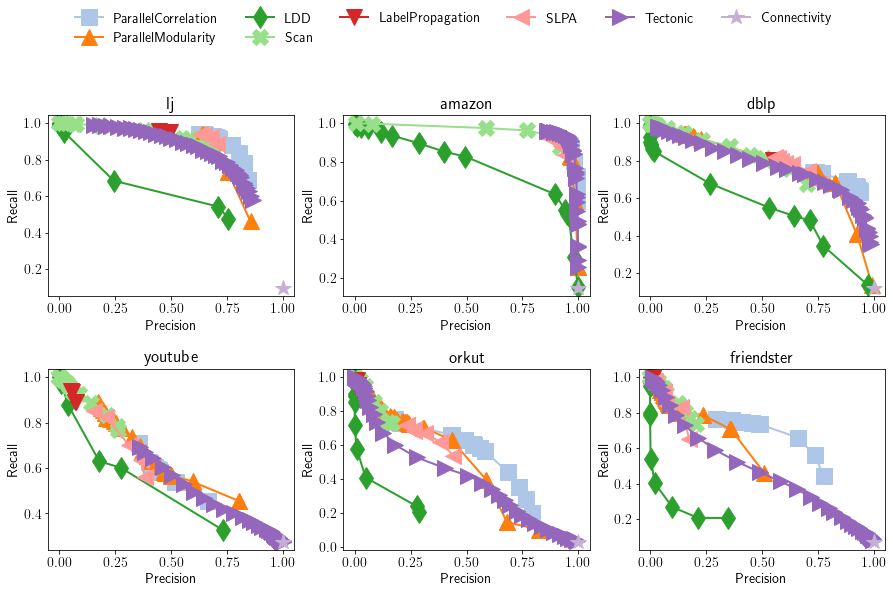

In [72]:
plotPRPareto(df_pr_pareto)

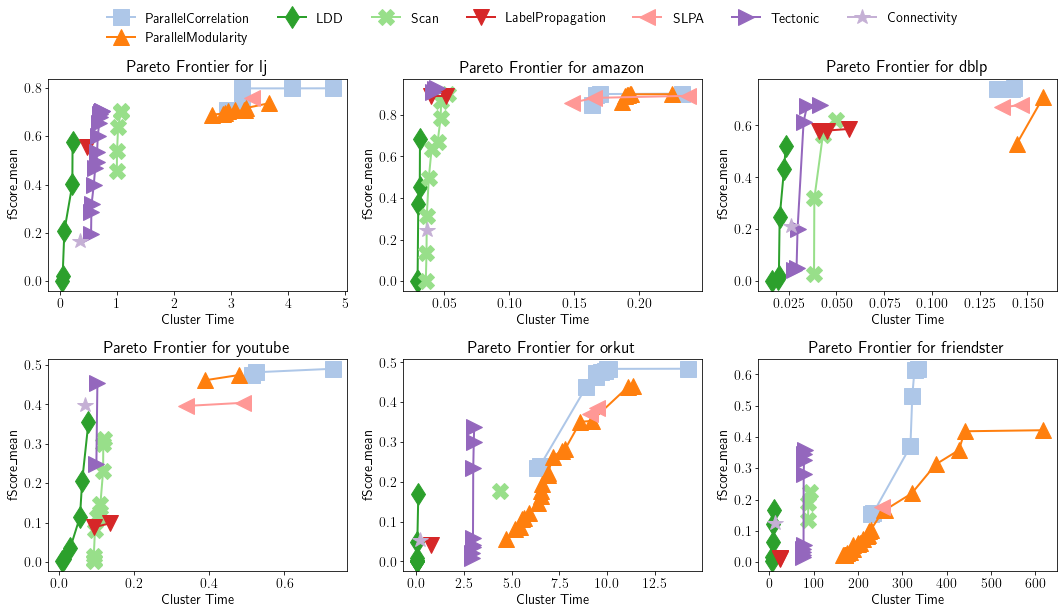

In [75]:
dfs, graphs = GetParetoDfs(df)
plt.rcParams.update({'font.size': 14})
plotPareto(dfs, graphs)
plt.tight_layout()
# plt.savefig("../results/out_time_f1_mnist.pdf", bbox_inches='tight')


In [77]:
# g = sns.FacetGrid(df[df["Input Graph"] == "lj"], col="Clusterer Name", col_wrap=4,
#                   xlim=(0, 1.1), ylim=(0,1.1))
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean")